In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.utils import shuffle
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [40]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_WIDTH)

BATCH_SIZE = 128
EPOCHS = 10

EMOTIONS = os.listdir("data")
EMOTIONS.remove("labels.csv")

In [19]:
emotions_dict = {emotion: i for i, emotion in enumerate(EMOTIONS)}
emotions_dict

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [20]:
labels_df = pd.read_csv("data/labels.csv")
labels_df.head()

,pth,label
0,anger/image0000006.jpg,surprise
1,anger/image0000007.jpg,anger
2,anger/image0000012.jpg,anger
3,anger/image0000035.jpg,fear
4,anger/image0000060.jpg,anger


In [21]:
filenames_list = []

for emotion in EMOTIONS:
    for photo in os.listdir("data/" + emotion):
        filenames_list.append(emotion + "/" + photo)

files_df = pd.DataFrame({"filename": filenames_list})
files_df.head()
    

,filename
0,anger/image0000006.jpg
1,anger/image0000007.jpg
2,anger/image0000012.jpg
3,anger/image0000035.jpg
4,anger/image0000060.jpg


In [22]:
files_df[files_df.duplicated()]

,filename


In [23]:
df = pd.merge(labels_df, files_df, left_on = "pth", right_on = "filename", how = "inner")
df.head()

,pth,label,filename
0,anger/image0000006.jpg,surprise,anger/image0000006.jpg
1,anger/image0000007.jpg,anger,anger/image0000007.jpg
2,anger/image0000012.jpg,anger,anger/image0000012.jpg
3,anger/image0000035.jpg,fear,anger/image0000035.jpg
4,anger/image0000060.jpg,anger,anger/image0000060.jpg


In [51]:
images = []
labels = []

for row in tqdm(df.itertuples()):
    img = cv2.imread("data" + "/" + row[1])

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    resized_img = cv2.resize(img, IMAGE_SIZE)
    
    if np.max(resized_img) > 1:
        norm_img = resized_img / 255
    else:
        norm_img = resized_img
    
    images.append(norm_img)
    labels.append(emotions_dict[row[2]])

images = np.array(images, dtype = np.float32)
labels = np.array(labels, dtype = np.float32)

31002it [06:16, 82.23it/s] 


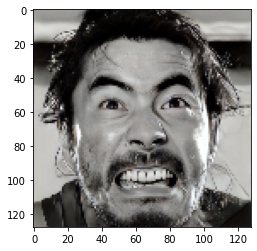

In [58]:
plt.imshow(images[3])

In [59]:
images[3].shape

(128, 128, 3)

In [60]:
images, labels = shuffle(images, labels, random_state = 42)

In [61]:
y_encoder = OneHotEncoder()
labels = y_encoder.fit_transform(labels.reshape(-1, 1))
labels = labels.toarray()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [63]:
y_train.shape

(26351, 8)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [65]:
y_train.shape

(21080, 8)

In [82]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding = 'Same', input_shape=(IMAGE_WIDTH, IMAGE_WIDTH, CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(24, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(emotions_dict), activation='softmax'))

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ['accuracy'])

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 24)        3480      
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 24)      

In [68]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [84]:
history = model.fit(X_train, 
          y_train, 
          epochs = 5*EPOCHS,
          batch_size = BATCH_SIZE,
          validation_data = (X_val, y_val),
          callbacks = [earlystop]
          )

Epoch 1/50
165/165 [==============================] - 118s 711ms/step - loss: 2.6543 - accuracy: 0.1815 - val_loss: 2.9282 - val_accuracy: 0.1347
Epoch 2/50
165/165 [==============================] - 116s 701ms/step - loss: 2.1199 - accuracy: 0.2380 - val_loss: 2.4440 - val_accuracy: 0.1979
Epoch 3/50
165/165 [==============================] - 116s 702ms/step - loss: 1.8835 - accuracy: 0.3016 - val_loss: 2.2071 - val_accuracy: 0.1169
Epoch 4/50
165/165 [==============================] - 118s 713ms/step - loss: 1.7120 - accuracy: 0.3567 - val_loss: 1.8644 - val_accuracy: 0.2889
Epoch 5/50
165/165 [==============================] - 119s 723ms/step - loss: 1.6067 - accuracy: 0.3976 - val_loss: 1.4948 - val_accuracy: 0.4295
Epoch 6/50
165/165 [==============================] - 119s 722ms/step - loss: 1.5348 - accuracy: 0.4243 - val_loss: 1.4256 - val_accuracy: 0.4620
Epoch 7/50
165/165 [==============================] - 119s 724ms/step - loss: 1.4741 - accuracy: 0.4452 - val_loss: 1.4057 -

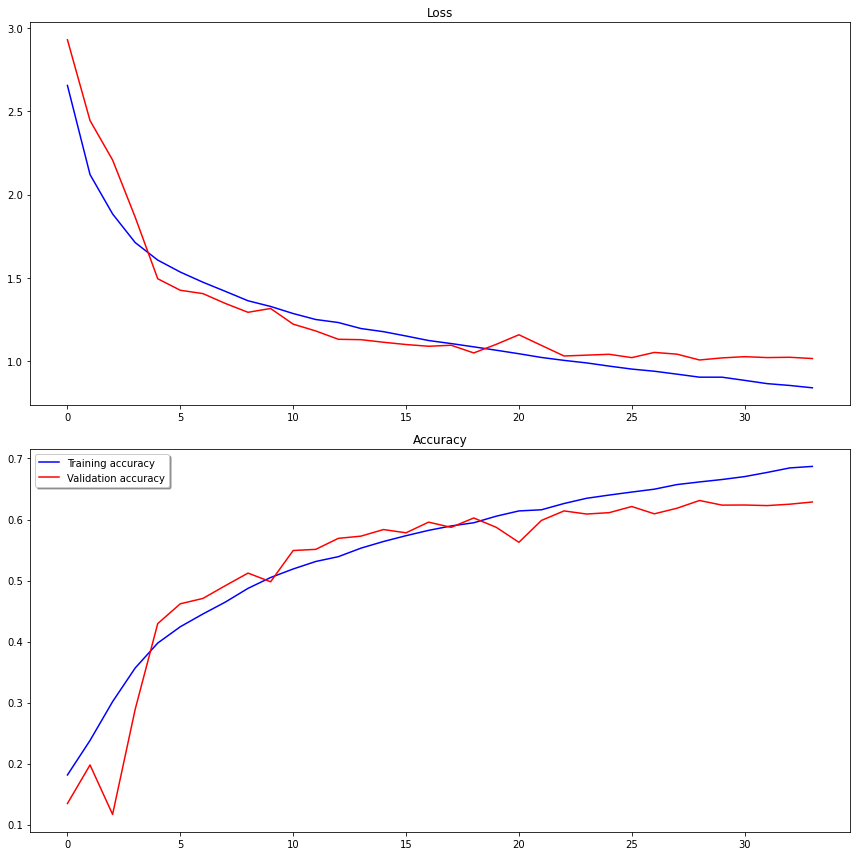

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label = "Training loss")
ax1.plot(history.history['val_loss'], color='r', label = "Validation loss")
ax1.set_title("Loss")

ax2.plot(history.history['accuracy'], color='b', label = "Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label = "Validation accuracy")
ax2.set_title("Accuracy")


legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [86]:
model.save('models/model_2.h5')

In [87]:
test_loss = model.evaluate(X_test, y_test)
test_loss

146/146 [==============================] - 7s 50ms/step - loss: 1.0349 - accuracy: 0.6263


[1.0349469184875488, 0.6263169050216675]

In [88]:
y_pred = model.predict(X_test)

146/146 [==============================] - 7s 49ms/step


In [89]:
y_pred[0]

array([2.8339953e-03, 1.1242445e-05, 8.2645216e-04, 7.9751486e-01,
       3.5012495e-06, 2.0802760e-04, 6.8592071e-06, 1.9859517e-01],
      dtype=float32)

In [90]:
inv_emotions_dict = {v: k for k, v in emotions_dict.items()}
inv_emotions_dict

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [91]:
y_pred_cat = [inv_emotions_dict[list(pred).index(max(list(pred)))] for pred in y_pred]
y_test_cat= [inv_emotions_dict[list(pred).index(max(list(pred)))] for pred in y_test]

In [92]:
y_pred_cat[0]

'fear'

<AxesSubplot:>

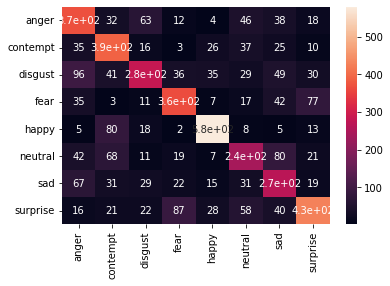

In [93]:
confusion_mtx = confusion_matrix(y_test_cat, y_pred_cat)
sns.heatmap(confusion_mtx, annot=True, xticklabels=emotions_dict.keys(), yticklabels=emotions_dict.keys())

In [98]:
y_df = pd.DataFrame({"y_test": y_test_cat, "y_pred": y_pred_cat})
y_df["correct"] = np.where(y_df["y_test"] == y_df["y_pred"], True, False)
y_df

,y_test,y_pred,correct
0,fear,fear,True
1,fear,fear,True
2,contempt,disgust,False
3,anger,disgust,False
4,contempt,contempt,True
...,...,...,...
4646,disgust,neutral,False
4647,contempt,contempt,True
4648,surprise,anger,False
4649,happy,happy,True


In [104]:
y_wrong = y_df[y_df["correct"] == False ]
y_wrong

,y_test,y_pred,correct
2,contempt,disgust,False
3,anger,disgust,False
5,fear,surprise,False
6,happy,contempt,False
7,disgust,anger,False
...,...,...,...
4629,sad,anger,False
4640,disgust,neutral,False
4645,anger,surprise,False
4646,disgust,neutral,False


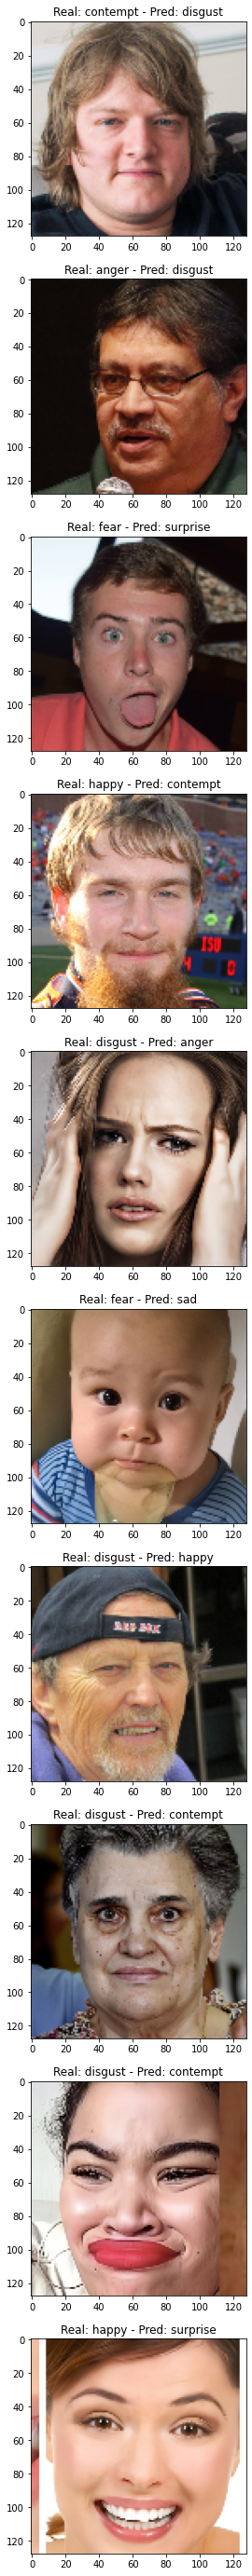

In [110]:
lenght = 10

fig, ax = plt.subplots(lenght, 1, figsize=(5, lenght*5))

i = 0
for row in y_wrong[:lenght].itertuples():
    ax[i].set_title("Real: {} - Pred: {}".format(row[1], row[2]))
    ax[i].imshow(X_test[row[0]])
    i += 1